In [81]:
import argparse
import json
import logging
import sys

import copy
import numpy as np
import pandas as pd
import pdb

import glob
import os
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

import loki
from loki.util import constraints, postprocessing
from loki.solver import sat
from loki.util.postprocessing import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
## add progress bar showing upload to postgres
## print out some model variables while sat solving
## remove error messages

# Setting up parameters

In [83]:

os.chdir("/flash1/pari/loki")
parser = argparse.ArgumentParser(description='Run Loki.')
parser.add_argument('--config', '-c', default='application.conf')
parser.add_argument('--workload', '-w', default='imdb')
parser.add_argument('--db',  default='imdb')
parser.add_argument('--table', '-t', default='n')
parser.add_argument('--vars_per_col', '-n', default=1000)
parser.add_argument('--logfile', '-lf', default='logs/loki.log')
parser.add_argument('--verbose', '-v', default=False, action='store_true')
#args = parser.parse_args()
args = parser.parse_args(args=[])

# Input Files (IR of Parsed Query Workload)

In [84]:
loki.load_config(args.config)
c_df = pd.read_csv(loki.config[args.workload]['constraints_df'])
c_df = c_df.sample(frac=1.0)
c_df.head(5)

,exprhash,RowCount,InputCardinality,RowSql,Column,input,jobid,Op,Value,Selectivity
78337,192086615593440370081424085026794314437393888840,1,12,SELECT COUNT(*) from role_type AS rt WHERE rt....,rt.role,rt,3025,=,'writer',0.083333
31685,49796300651249451890224945710663208019125912574,1867,4167491,SELECT COUNT(*) from name AS n WHERE n.name_pc...,n.name_pcode_nf,n,1212,=,'M6356',0.000448
77005,1210763724728247407006325998643557482360188776754,58671,14835720,SELECT COUNT(*) from movie_info AS mi2 WHERE m...,mi2.info,mi,2980,=,'French',0.003955
39070,1221107723368066237473692858264651231935865466072,2456181,2528312,SELECT COUNT(*) from title AS t WHERE t.produc...,t.production_year,t,1522,<=,2015,0.971471
43458,141937853058656590114794529107381368624623124016,38819,14835720,SELECT COUNT(*) from movie_info AS mi1 WHERE m...,mi1.info,mi,1680,=,'RAT:1.37 : 1',0.002617


# Converting the cardinalities ---> SAT constraints, and solving it for a potential database that satisfies those constraints

In [85]:
import warnings
warnings.filterwarnings('ignore')
import time

start = time.time()
logging.basicConfig(
    level=logging.DEBUG if args.verbose else logging.INFO,
    format="%(asctime)s %(levelname)-8s [%(name)s]  %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    handlers=[logging.FileHandler(args.logfile), logging.StreamHandler()])

logger = logging.getLogger('stdout')

#logger.info('Loki initialized with configuration:\n%s' % json.dumps(loki.config, sort_keys=True, indent=4))

print('Loki initialized with configuration: \n{}'.format(json.dumps(loki.config, sort_keys=True, indent=4)))
df = pd.read_csv(loki.config[args.workload]['df'])
tables = set(df['input'])
table_columns = {table: set(df['column'].where(df['input'] == table).dropna()) for table in tables}

table = args.table
orig_table = table
# table = '"{}"'.format(table)

columns = table_columns[table]

constraints_df = constraints.get_constraints_df(c_df, table)
print("Operators used: ", set(constraints_df["Op"]))

table_cardinality = constraints.get_table_cardinality(constraints_df)
co_optimized_columns = constraints.get_co_optimized_columns(constraints_df, columns)
programs = constraints.get_programs(co_optimized_columns)

leftover_constraints = []

vars_per_col = args.vars_per_col

solutions = []

constraints_df = constraints_df[constraints_df["Value0"] != "None"]
constraints_df = constraints_df[constraints_df["Value1"] != "None"]
constraints_df = constraints_df[constraints_df["Value"] != "None"]
# pdb.set_trace()
for program in programs:
    #logger.info(f'Solving: {program}')
    print(f'Solving: {program}')
    constraints_ = constraints.parse_constraints(program, constraints_df)
    model, vars, cols, col_values_ids_map = sat.build_model(program, constraints_, leftover_constraints, table_cardinality, vars_per_col)
    solution = sat.solve(model, vars, cols, col_values_ids_map, vars_per_col)
    solutions.append(solution)
    #logger.info(f'Solved: {program}')
    print(f'Solved: {program}')

# Combine all programs' solutions into a single dictionary solution
full_solution = {k: v for s in solutions for k, v in s.items()}

postprocessing.apply_leftover_constraints(full_solution, leftover_constraints)
solution_df = postprocessing.solution_to_df(full_solution)
final_solution_df = postprocessing.scale_solution_df(solution_df, table_cardinality, vars_per_col)

final_solution_df.to_csv(f'results/{orig_table}.csv')

print("Generating solutions took: ", time.time()-start)

Loki initialized with configuration: 
{
    "imdb": {
        "constraints_df": "sample-data/literal_df.csv",
        "df": "sample-data/op_df.csv"
    }
}
Operators used:  {'like', '=|=', '='}
Solving: {'name'}
Variable 1: name_0_%hel%
Variable 25001: name_161_%co%
Variable 50001: name_322_%ba%
Variable 75001: name_483_%richard%
Variable 100001: name_645_%lov%
Variable 125001: name_806_%ir%
Variable 150001: name_967_%ne%
Number of SAT variables: 155000
Stopping after 75 constraints!
Status = OPTIMAL
Solved: {'name'}
Solving: {'surname_pcode', 'name_pcode_cf', 'gender', 'name_pcode_nf'}
Variable 1: gender_0_f
Variable 2001: surname_pcode_1000_P4
Variable 27001: surname_pcode_1126_%p64%
Variable 52001: surname_pcode_1253_%f52%
Variable 77001: surname_pcode_1380_M63
Variable 102001: surname_pcode_1507_W5
Variable 127001: surname_pcode_1634_O165
Variable 152001: surname_pcode_1761_A45
Variable 177001: surname_pcode_1888_F63
Variable 199001: name_pcode_cf_2000_M6262
Variable 224001: name_p

# Exploring the solution

In [86]:
tmp = final_solution_df.dropna()
tmp.sample(frac=0.1).head(10)

,name,gender,surname_pcode,name_pcode_cf,name_pcode_nf
227565,%menez%,m,L235,B4525,R1635
211217,%le%,f,%p54%,P6235,S3156
462753,%le%,f,L,R1525,J5165
158954,%le%,f,O2,%w4%,T6253
235028,%jim%,f,%g4%,R25,M6216
163537,%le%,f,C63,D4626,J2432
313539,%shei%,m,J525,%b4%,M6232
58631,%le%,f,%h%,M6253,H526
172434,%le%,m,%f52%,G6262,R2634
140035,%le%,f,L2,%c%,H6432


# Uploading the created table to Postgres

In [87]:
DKIND="s1"
upload_to_postgres(final_solution_df, args.db, args.table, DKIND, shuffle=True)

uploading to postgres took:  180.29


# Setting up execution result directories

In [96]:
import sys
import os

os.chdir("/spinning/pari/WorkloadCharacterization")

try:
    os.rmdir("./new_results")
except Exception as e:
    pass

try:
    os.mkdir("./new_results")
except:
    pass

NUMQ = 100

# Executing Workload Queries on true data

In [97]:
CMD = "python3 eval_data.py --data_kind true_cols --num_queries {} \
--inp_to_eval n --port 5432 --workload ceb --db_name imdb --result_dir new_results".format(NUMQ)
out = os.system(CMD)

data/ceb-all/sqls/dfs/expr_df.csv
Number of sqls to evaluate: 100
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f','m') AND n.name_pcode_nf in ('C6231','E4213','F6362','F6525','J513','M6251','M6263','P3625','R1632','R1636','R2631','R2632','S2153')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('m') AND n.name_pcode_nf in ('A6361','D1326','D1352','G6262','J5241','J5245','J5263','L2142','M6216','S3151')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f','m')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f') AND n.surname_pcode in ('B2','B6','B62','B653','C2','C5','J52','J525','L15','L52','M62','P62','R3','W425')
SELECT COUNT(*) from n_true_cols AS n WHERE n.gender in ('f','m') AND n.name_pcode_nf in ('A4236','A5356','A5361','E3631','J25','M2412','M2415','M6242','M6352','P3656','R1632','S2525','S3541','V2362')
SELECT COUNT(

# Executing Workload Queries on our Generated Data

In [98]:
CMD2 = "python3 eval_data.py --data_kind {} --num_queries {} \
--inp_to_eval n --port 5432 --workload ceb --db_name imdb --result_dir new_results".format(DKIND, NUMQ)
out = os.system(CMD2)

data/ceb-all/sqls/dfs/expr_df.csv
Number of sqls to evaluate: 100
SELECT COUNT(*) from n_s1 AS n WHERE n.gender in ('m')
SELECT COUNT(*) from n_s1 AS n WHERE n.gender in ('f','m') AND n.name_pcode_nf in ('C6231','E4213','F6362','F6525','J513','M6251','M6263','P3625','R1632','R1636','R2631','R2632','S2153')
SELECT COUNT(*) from n_s1 AS n WHERE n.gender in ('f')
SELECT COUNT(*) from n_s1 AS n WHERE n.gender in ('m') AND n.name_pcode_nf in ('A6361','D1326','D1352','G6262','J5241','J5245','J5263','L2142','M6216','S3151')
SELECT COUNT(*) from n_s1 AS n WHERE n.gender in ('f','m')
SELECT COUNT(*) from n_s1 AS n WHERE n.gender in ('f') AND n.surname_pcode in ('B2','B6','B62','B653','C2','C5','J52','J525','L15','L52','M62','P62','R3','W425')
SELECT COUNT(*) from n_s1 AS n WHERE n.gender in ('f','m') AND n.name_pcode_nf in ('A4236','A5356','A5361','E3631','J25','M2412','M2415','M6242','M6352','P3656','R1632','S2525','S3541','V2362')
SELECT COUNT(*) from n_s1 AS n WHERE n.gender in ('m') AND n.n

# Exploring the results

In [91]:
def extract_val(d, key):
    val_start = d.find(key)
    val_end = val_start + d[val_start:].find(",")
    if val_end < val_start:
        val_end = val_start + d[val_start:].find(")")
    val = d[val_start:val_end].split("=")[1]
    return val.replace("'", "")

def load_logs(logfile):
    with open(logfile, "r") as f:
        data = f.readlines()
    
    retdata = defaultdict(list)
    alg = None
    #port = None
    
    for d in data:
        if "data_kind" in d:
            #d = d.replace("\n", "")
            #d = d.replace(" ", "")
            data_kind = extract_val(d, "data_kind")
            inp_to_eval = extract_val(d, "inp_to_eval")
            nq = int(extract_val(d, "num_queries"))
            wk = extract_val(d, "workload")
            if "port" not in d:
                break
            
            port = int(extract_val(d, "port"))
            skip_likes = int(extract_val(d, "skip_likes"))
            
        if "-->" in d:
            linedata = d.split(" ")
            ehash = linedata[5]
            rt = float(linedata[-1].replace("\n", ""))
            rep = int(linedata[-5])
            qerr = float(linedata[-3].replace("QErr:", ""))
            
            retdata["ehash"].append(ehash)
            retdata["rt"].append(rt)
            retdata["rep"].append(rep)
            retdata["data_kind"].append(str(data_kind))
            retdata["inp_to_eval"].append(inp_to_eval)
            retdata["num_queries"].append(nq)
            retdata["workload"].append(wk)
            retdata["port"].append(port)
            retdata["skip_likes"].append(skip_likes)
            retdata["qerr"].append(qerr)
            
    df = pd.DataFrame(retdata)
    return df

In [92]:
LOGDIR = "./new_results/"
fns = glob.glob(LOGDIR + "*.log")
dfs = []

for fn in fns:
    df = load_logs(fn)
    dfs.append(df)
df = pd.concat(dfs)

In [93]:
mapping = {}
mapping["true_cols"] = "True Data"
mapping["gen_shuffle"] = "Generated Data"
mapping["s1"] = "Generated Data"

df["data_kind"] = df.apply(lambda x: mapping[x["data_kind"]] , axis=1)

In [94]:
tmp = df.groupby(["ehash", "data_kind"])[["rt"]].mean().reset_index()
edf = tmp.set_index(['ehash', 'data_kind'])['rt'].unstack().reset_index()

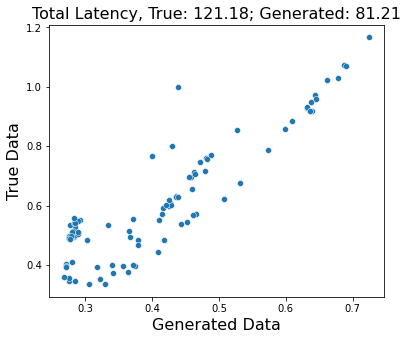

In [95]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,5))
true_rt = round(df.groupby(["data_kind"])["rt"].sum()["True Data"], 2)
gen_rt = round(df.groupby(["data_kind"])["rt"].sum()["Generated Data"], 2)

title = "Total Latency, True: {}; Generated: {}".format(true_rt, gen_rt)

sns.scatterplot(data=edf, x = "Generated Data", y="True Data", alpha=1.0, ax=ax)

ax.set_ylabel("True Data", fontsize=16)
ax.set_xlabel("Generated Data", fontsize=16)

plt.title(title, fontsize=16)

#FN= "{}-{}-scatterplot.pdf".format(INP , NUMQ)
#plt.savefig(FN, bbox_inches="tight")
plt.show()

In [80]:
df

,ehash,rt,rep,data_kind,inp_to_eval,num_queries,workload,port,skip_likes,qerr
0,1412706111350165054529954383171903240337882399016,0.382931,0,True Data,n,100,ceb,5432,0,1.000000
1,845697540102295928657811596227970506096002273384,1.014524,0,True Data,n,100,ceb,5432,0,2.545024
2,84075949613328714275869842821526357397337767243,0.337060,0,True Data,n,100,ceb,5432,0,1.000000
3,1331203710710213837019143823676324531895931998752,0.630571,0,True Data,n,100,ceb,5432,0,1.760590
4,245567878873194242657445459190732968648046452375,0.440278,0,True Data,n,100,ceb,5432,0,1.000000
...,...,...,...,...,...,...,...,...,...,...
95,87609295975210428796121459944783091656178360857,0.332205,0,Generated Data,n,100,ceb,5432,0,2.095992
96,336594272451225151551248416213388605151122440612,0.241783,0,Generated Data,n,100,ceb,5432,0,7513.000000
97,933528829179586390473294743220524459138002141976,0.300074,0,Generated Data,n,100,ceb,5432,0,5.254020
98,86595083883028498720841723952849009327274442912,0.220166,0,Generated Data,n,100,ceb,5432,0,13875.000000


In [62]:
edf

data_kind,ehash,Generated Data,True Data
0,1008008897179342611118423694149411029507064764932,0.000105,0.617839
1,1035704533657090929604109085514208032053601153212,0.000113,0.627586
2,1099138279516972172753043334922897705729944443792,0.000115,0.580120
3,1101445597102558006041011375790825831166481354375,0.000109,0.684442
4,1104450627206335214552523134893362187670132493458,0.000094,0.343299
...,...,...,...
95,95009784635217515347947441115657257270457873274,0.000102,0.344583
96,96507708544966849249217706685061347700434711788,0.000094,0.493413
97,98243461041236189828924585397853349301873038340,0.000091,0.350429
98,987523020907590039564653707066296064026503604875,0.000091,0.491810


In [63]:
tmp

,ehash,data_kind,rt
0,1008008897179342611118423694149411029507064764932,Generated Data,0.000105
1,1008008897179342611118423694149411029507064764932,True Data,0.617839
2,1035704533657090929604109085514208032053601153212,Generated Data,0.000113
3,1035704533657090929604109085514208032053601153212,True Data,0.627586
4,1099138279516972172753043334922897705729944443792,Generated Data,0.000115
...,...,...,...
195,98243461041236189828924585397853349301873038340,True Data,0.350429
196,987523020907590039564653707066296064026503604875,Generated Data,0.000091
197,987523020907590039564653707066296064026503604875,True Data,0.491810
198,993809436969448239583044940420692449354037993916,Generated Data,0.000097
